<a href="https://colab.research.google.com/github/paula-33/Bootcamp_DS/blob/main/02_Classificac%CC%A7a%CC%83o_binaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Pipeline Completo de Manutenção Preditiva: Para o modelo preditivo Binário.**

Este script implementa um pipeline de ponta a ponta para um problema de classificação
**binária** em manutenção preditiva. O objetivo é prever a ocorrência de falhas em máquinas
com base em dados de sensores IoT.

O script está estruturado nas seguintes etapas:
1.  **Configuração Inicial**: Importação de bibliotecas e configuração de visualizações.
2.  **Carregamento e Limpeza dos Dados**: Leitura do dataset, padronização das colunas de
    falha e tratamento de valores sentinela (anomalias físicas).
3.  **Engenharia de Features**: Criação de uma nova feature ('potencia_calculada') com
    base em princípios físicos para aumentar o poder preditivo do modelo.
4.  **Pré-processamento e Construção do Pipeline**: Definição de um pipeline robusto
    com *ColumnTransformer* para tratar features numéricas e categóricas de forma
    diferenciada, incluindo imputação de dados ausentes e escalonamento.
5.  **Visualizações de Transformações**: Demonstração do efeito do escalonamento
    (RobustScaler) e do balanceamento de classes (SMOTE) nos dados.
6.  **Modelagem e Avaliação Comparativa**: Treinamento e avaliação de múltiplos
    modelos de classificação, incluindo um baseline (Regressão Logística) e modelos
    avançados (Random Forest, XGBoost, LightGBM). Duas estratégias para lidar com o
    desbalanceamento são comparadas: SMOTE e ponderação de classes interna dos modelos.
7.  **Análise Gráfica dos Resultados**: Geração de matrizes de confusão, curvas ROC e
    curvas Precision-Recall para comparar visualmente a performance dos modelos.
8.  **Serialização do Pipeline Vencedor**: Salvamento do pipeline do modelo com melhor
    performance em um arquivo para futura aplicação em produção (deploy).


Decisões Técnicas Chave:
-   **Imputação com Mediana**: Escolhida por ser robusta a outliers, comuns em dados de sensores.
-   **RobustScaler**: Utilizado para o escalonamento de features, pois minimiza o impacto de outliers.
-   **SMOTE (Synthetic Minority Over-sampling Technique)**: Aplicado exclusivamente no conjunto de
    treino através do pipeline do `imblearn` para evitar vazamento de dados (data leakage).
-   **Avaliação com Métricas Apropriadas**: Foco em Recall, F1-Score e AUPRC, que são mais
    informativas que a acurácia em cenários de dados desbalanceados.

In [ ]:
# ==============================================================================
# 1. CONFIGURAÇÃO INICIAL E IMPORTAÇÃO DE BIBLIOTECAS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

# Modelos e Ferramentas de Pré-processamento do Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# Modelos de Classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Ferramentas para Lidar com Desbalanceamento (da biblioteca imbalanced-learn)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Configurações de Visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


In [ ]:
# ==============================================================================
# 2. CARREGAMENTO E LIMPEZA DOS DADOS
# ==============================================================================
print("--- Iniciando Carga e Limpeza dos Dados ---")
# Carregar o dataset

df = pd.read_csv('bootcamp_train.csv')
df.columns = [col.lower().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]

# --- Limpeza de Dados ---
# Decisão 1: Padronizar colunas de falha.
# As colunas alvo possuem múltiplos formatos ('sim', 'Não', 'False', etc.).
# É necessário convertê-las para um formato binário (0/1) para análise e modelagem.
falhas_colunas = [    'falha_maquina', 'fdf_falha_desgaste_ferramenta', 'fdc_falha_dissipacao_calor',
    'fp_falha_potencia', 'fte_falha_tensao_excessiva', 'fa_falha_aleatoria']

map_sim_nao = {
    'sim': 1, 'Sim': 1, True: 1, 'True': 1, '1': 1, 1:1,
    'não': 0, 'nao': 0, 'Não': 0, 'N': 0, False: 0, 'False': 0, '0': 0, 0: 0, '-': 0 }

for col in falhas_colunas:
    # Assegura que todos os valores sejam strings antes de mapear para lidar com tipos mistos
    df[col] = df[col].astype(str).map(map_sim_nao).fillna(0).astype(int)

print("\nColunas de falha padronizadas para formato binário (0/1).")

# ---  Tratamento de Anomalias (Valores Sentinela) ---
# Decisão 2: Tratar valores fisicamente impossíveis como dados ausentes.
# Valores negativos recorrentes em sensores (ex: -36.0 em temperatura) são
# interpretados como códigos de erro (valores sentinela), não como medições reais.
# Substituí-los por NaN permite um tratamento unificado na etapa de imputação.

valores_sentinela = {
    'temperatura_ar': -36.0,
    'temperatura_processo': -38.0,
    'velocidade_rotacional': -161.0,
    'desgaste_da_ferramenta': -202.0
}

print("\n--- Métricas de Qualidade: Detecção de Anomalias ---")
for col, valor in valores_sentinela.items():
    count_before = (df[col] == valor).sum()
    if count_before > 0:
        print(f"Encontrados {count_before} valores sentinela ({valor}) na coluna '{col}'. Substituindo por NaN.")
        df[col] = df[col].replace(valor, np.nan)


--- Iniciando Carga e Limpeza dos Dados ---

Colunas de falha padronizadas para formato binário (0/1).

--- Métricas de Qualidade: Detecção de Anomalias ---
Encontrados 3132 valores sentinela (-36.0) na coluna 'temperatura_ar'. Substituindo por NaN.
Encontrados 2939 valores sentinela (-38.0) na coluna 'temperatura_processo'. Substituindo por NaN.
Encontrados 2968 valores sentinela (-161.0) na coluna 'velocidade_rotacional'. Substituindo por NaN.
Encontrados 3439 valores sentinela (-202.0) na coluna 'desgaste_da_ferramenta'. Substituindo por NaN.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             35260 non-null  int64  
 1   id_produto                     35260 non-null  object 
 2   tipo                           35260 non-null  object 
 3   temperatura_ar                 31512 non-null  float64
 4   temperatura_processo           31722 non-null  float64
 5   umidade_relativa               35260 non-null  float64
 6   velocidade_rotacional          31541 non-null  float64
 7   torque                         34637 non-null  float64
 8   desgaste_da_ferramenta         30869 non-null  float64
 9   falha_maquina                  35260 non-null  int64  
 10  fdf_falha_desgaste_ferramenta  35260 non-null  int64  
 11  fdc_falha_dissipacao_calor     35260 non-null  int64  
 12  fp_falha_potencia              35260 non-null 

In [ ]:
df.shape

(35260, 15)

In [ ]:
# ==============================================================================
# 4. ENGENHARIA DE FEATURES
# ==============================================================================
print("\n--- Iniciando Engenharia de Features ---")
# --- Criação de Feature ---
# Decisão 3: Criar 'potencia_calculada'.
# A potência mecânica é o produto do torque pela velocidade angular.
# Esta feature combina duas variáveis correlacionadas em uma única com
# significado físico, potencialmente melhorando o poder preditivo do modelo.
# Fórmula: Potência (kW) = (Torque (Nm) * Velocidade (rpm)) / 9550
df['potencia_calculada'] = (df['torque'] * df['velocidade_rotacional']) / 9550
print("Feature 'potencia_calculada' criada com sucesso.")



--- Iniciando Engenharia de Features ---
Feature 'potencia_calculada' criada com sucesso.


In [ ]:
df.drop(columns=['id', 'id_produto'] + falhas_colunas)

,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,potencia_calculada
0,L,298.3,309.1,90.0,1616.0,31.1,195.0,5.262576
1,L,298.2,308.4,90.0,1388.0,53.8,137.0,7.819309
2,L,298.2,307.8,90.0,1528.0,31.1,NaN,4.976000
3,M,300.9,310.8,90.0,1599.0,33.0,7.0,5.525340
4,L,NaN,310.5,90.0,1571.0,33.9,NaN,5.576639
...,...,...,...,...,...,...,...,...
35255,L,300.1,311.4,90.0,1634.0,34.2,45.0,5.851602
35256,L,300.4,311.3,90.0,1597.0,36.2,112.0,6.053550
35257,L,300.6,NaN,90.0,1485.0,35.8,19.0,5.566806
35258,M,301.3,310.4,90.0,1577.0,37.3,43.0,6.159382


In [ ]:
# ==============================================================================
# 5. PREPARAÇÃO PARA MODELAGEM E CONSTRUÇÃO DO PIPELINE
# ==============================================================================
print("\n--- Construindo Pipelines de Pré-processamento e Modelagem ---")

# 5.1. Definição das Features (X) e Alvo (y)
# Remover colunas de ID e as falhas específicas, pois o alvo é a falha geral.
X = df.drop(columns=['id', 'id_produto'] + falhas_colunas)
y = df['falha_maquina']

# 5.2. Divisão Estratificada Treino-Teste
# --- Divisão dos Dados ---
# Decisão 4: Usar divisão estratificada.
# Garante que a proporção de classes (especialmente a minoritária) seja a mesma
# nos conjuntos de treino e teste, o que é crucial para uma avaliação válida.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Dados divididos em treino ({X_train.shape} amostras) e teste ({X_test.shape} amostras).")



--- Construindo Pipelines de Pré-processamento e Modelagem ---
Dados divididos em treino ((28208, 8) amostras) e teste ((7052, 8) amostras).


In [ ]:

# 5.3. Identificação de Tipos de Colunas para o ColumnTransformer
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# 5.4. Definição dos Pipelines de Pré-processamento
# --- Pipeline de Pré-processamento ---
# Decisão 5: Usar pipelines separados para features numéricas e categóricas.
# Numéricas: Imputação com mediana (robusto a outliers) e escalonamento com RobustScaler (também robusto a outliers).
# Categóricas: Imputação com a constante 'missing' (para tratar NaNs) e OneHotEncoder (para converter em formato numérico sem criar ordem artificial).
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Combinar os transformadores em um único objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantém colunas não especificadas (caso existam)
)


In [ ]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['temperatura_ar', 'temperatura_processo',
                                  'umidade_relativa', 'velocidade_rotacional',
                                  'torque', 'desgaste_da_ferramenta',
                                  'potencia_calculada']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['tipo'])])


--- Visualizando Efeito das Transformações ---


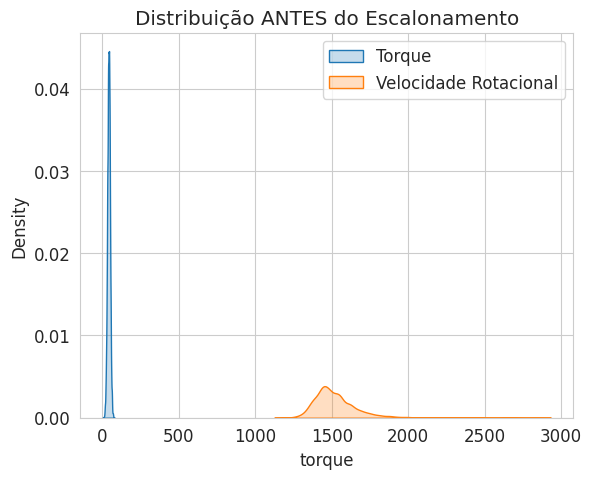

In [ ]:
# ==============================================================================
# 6. VISUALIZAÇÕES ANTES/DEPOIS DAS TRANSFORMAÇÕES
# ==============================================================================
print("\n--- Visualizando Efeito das Transformações ---")

# 6.1. Efeito do RobustScaler
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(X_train['torque'], label='Torque', fill=True)
sns.kdeplot(X_train['velocidade_rotacional'], label='Velocidade Rotacional', fill=True)
plt.title('Distribuição ANTES do Escalonamento')
plt.legend()

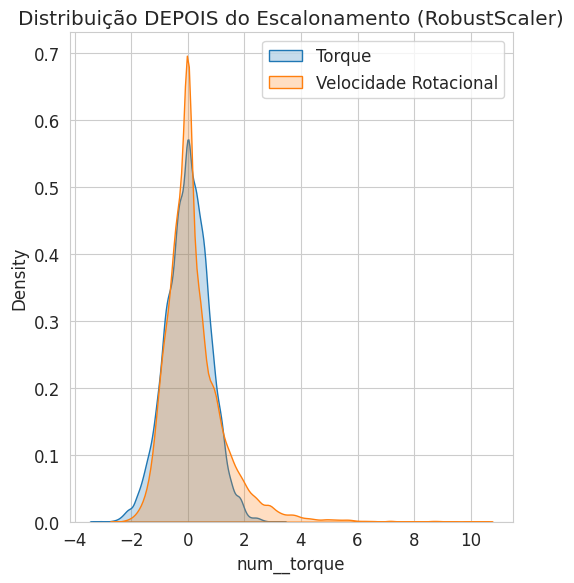


--- Métricas de Qualidade: Balanceamento de Classes ---
Distribuição de classes ANTES do SMOTE (treino): Counter({0: 27689, 1: 519})
Distribuição de classes DEPOIS do SMOTE (treino): Counter({0: 27689, 1: 27689})


In [ ]:

# Aplicar o pré-processador apenas para visualização
X_train_scaled_vis = preprocessor.fit_transform(X_train)
# Recuperar os nomes das colunas após a transformação
feature_names_out = preprocessor.get_feature_names_out()
X_train_scaled_vis_df = pd.DataFrame(X_train_scaled_vis, columns=feature_names_out)

plt.subplot(1, 2, 2)
sns.kdeplot(X_train_scaled_vis_df['num__torque'], label='Torque', fill=True)
sns.kdeplot(X_train_scaled_vis_df['num__velocidade_rotacional'], label='Velocidade Rotacional', fill=True)
plt.title('Distribuição DEPOIS do Escalonamento (RobustScaler)')
plt.legend()
plt.tight_layout()
plt.show()

# 6.2. Efeito do SMOTE
print("\n--- Métricas de Qualidade: Balanceamento de Classes ---")
print(f"Distribuição de classes ANTES do SMOTE (treino): {Counter(y_train)}")

# Aplicar SMOTE apenas para visualização
smote_vis = SMOTE(random_state=42)
X_train_smote_vis, y_train_smote_vis = smote_vis.fit_resample(X_train_scaled_vis, y_train)
print(f"Distribuição de classes DEPOIS do SMOTE (treino): {Counter(y_train_smote_vis)}")


--- Iniciando Treinamento e Avaliação dos Modelos ---

Treinando o modelo: Regressão Logística (Ponderada)...


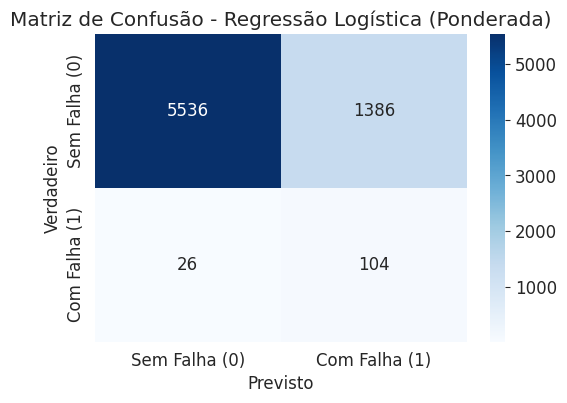


Treinando o modelo: Random Forest (SMOTE)...


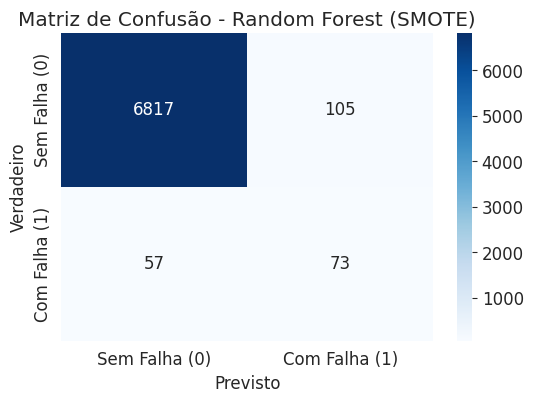


Treinando o modelo: XGBoost (Ponderado)...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:43:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


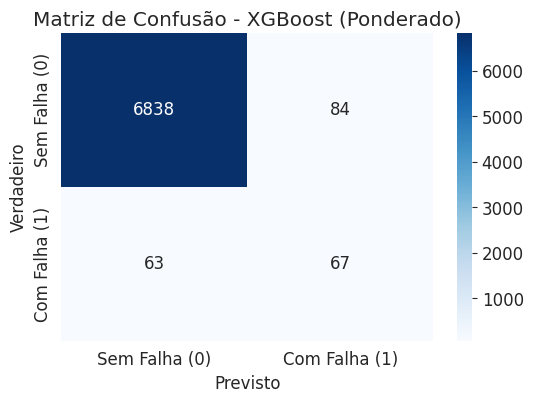


Treinando o modelo: XGBoost (SMOTE)...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:43:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


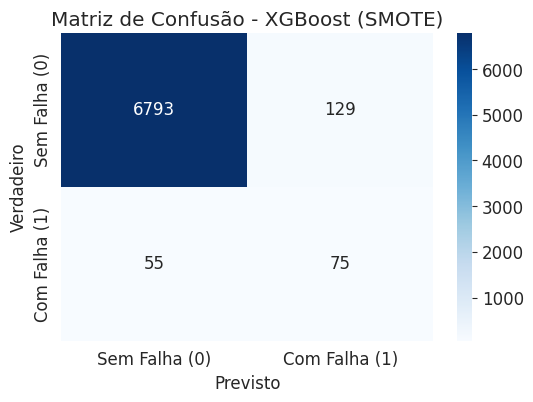


Treinando o modelo: LightGBM (Ponderado)...
[LightGBM] [Info] Number of positive: 519, number of negative: 27689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 28208, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018399 -> initscore=-3.976887
[LightGBM] [Info] Start training from score -3.976887


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


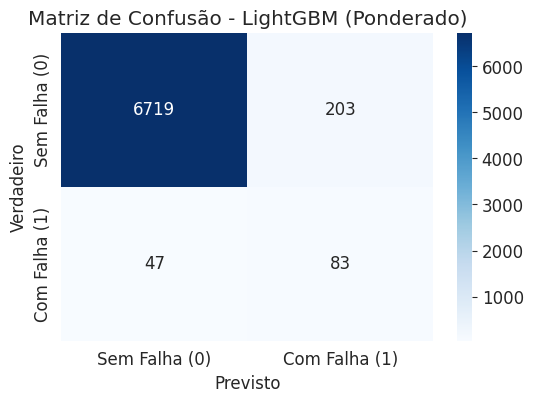


Treinando o modelo: LightGBM (SMOTE)...
[LightGBM] [Info] Number of positive: 27689, number of negative: 27689
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 55378, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


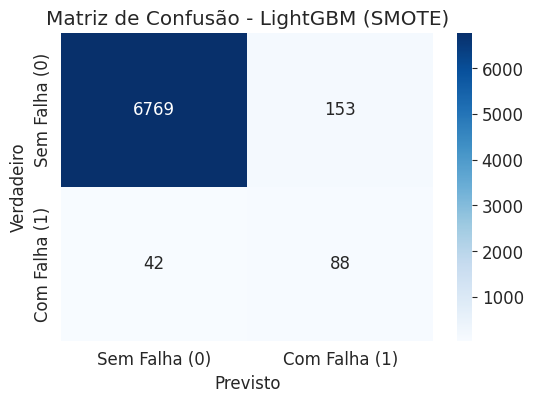

In [ ]:
# ==============================================================================
# 7. MODELAGEM E AVALIAÇÃO COMPARATIVA
# ==============================================================================
print("\n--- Iniciando Treinamento e Avaliação dos Modelos ---")

# ---  Estratégias de Modelagem ---
# Decisão 6: Comparar modelos com e sem SMOTE.
# Para modelos que possuem ponderação de classe interna (LogisticRegression, XGBoost, LightGBM),
# testamos a performance com essa funcionalidade.
# Para todos, testamos também com dados balanceados via SMOTE, usando o pipeline do imblearn
# para garantir que o SMOTE seja aplicado corretamente apenas nos dados de treino.

# Calcular scale_pos_weight para XGBoost e LightGBM
# A proporção de amostras negativas para positivas.
scale_pos_weight_value = Counter(y_train)[0] / Counter(y_train)[1]

# Dicionário para armazenar os modelos/pipelines
models = {
    "Regressão Logística (Ponderada)": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42))
    ]),
    "Random Forest (SMOTE)": ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    "XGBoost (Ponderado)": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                                         scale_pos_weight=scale_pos_weight_value, use_label_encoder=False, random_state=42))
    ]),
    "XGBoost (SMOTE)": ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                                         use_label_encoder=False, random_state=42))
    ]),
    "LightGBM (Ponderado)": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(objective='binary', metric='binary_logloss',
                                          scale_pos_weight=scale_pos_weight_value, random_state=42))
    ]),
    "LightGBM (SMOTE)": ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42))
    ])
}

# Dicionários para armazenar resultados
results = {}
predictions_proba = {}

# Loop para treinar e avaliar cada modelo
for name, model in models.items():
    print(f"\nTreinando o modelo: {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Armazenar resultados
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results[name] = {
        'Recall': report['1']['recall'],
        'Precision': report['1']['precision'],
        'F1-Score': report['1']['f1-score'],
        'AUC-ROC': auc(roc_curve(y_test, y_proba)[0], roc_curve(y_test, y_proba)[1]),
        'AUPRC': average_precision_score(y_test, y_proba)
    }
    predictions_proba[name] = y_proba

    # Plotar Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Sem Falha (0)', 'Com Falha (1)'],
                yticklabels=['Sem Falha (0)', 'Com Falha (1)'])
    plt.title(f'Matriz de Confusão - {name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()


--- Comparativo de Performance dos Modelos ---
                                   Recall  Precision  F1-Score   AUC-ROC  \
XGBoost (Ponderado)              0.515385   0.443709  0.476868  0.910809   
LightGBM (SMOTE)                 0.676923   0.365145  0.474394  0.922381   
Random Forest (SMOTE)            0.561538   0.410112  0.474026  0.911894   
XGBoost (SMOTE)                  0.576923   0.367647  0.449102  0.898121   
LightGBM (Ponderado)             0.638462   0.290210  0.399038  0.914086   
Regressão Logística (Ponderada)  0.800000   0.069799  0.128395  0.859188   

                                    AUPRC  
XGBoost (Ponderado)              0.490411  
LightGBM (SMOTE)                 0.566707  
Random Forest (SMOTE)            0.475242  
XGBoost (SMOTE)                  0.511434  
LightGBM (Ponderado)             0.534353  
Regressão Logística (Ponderada)  0.215222  


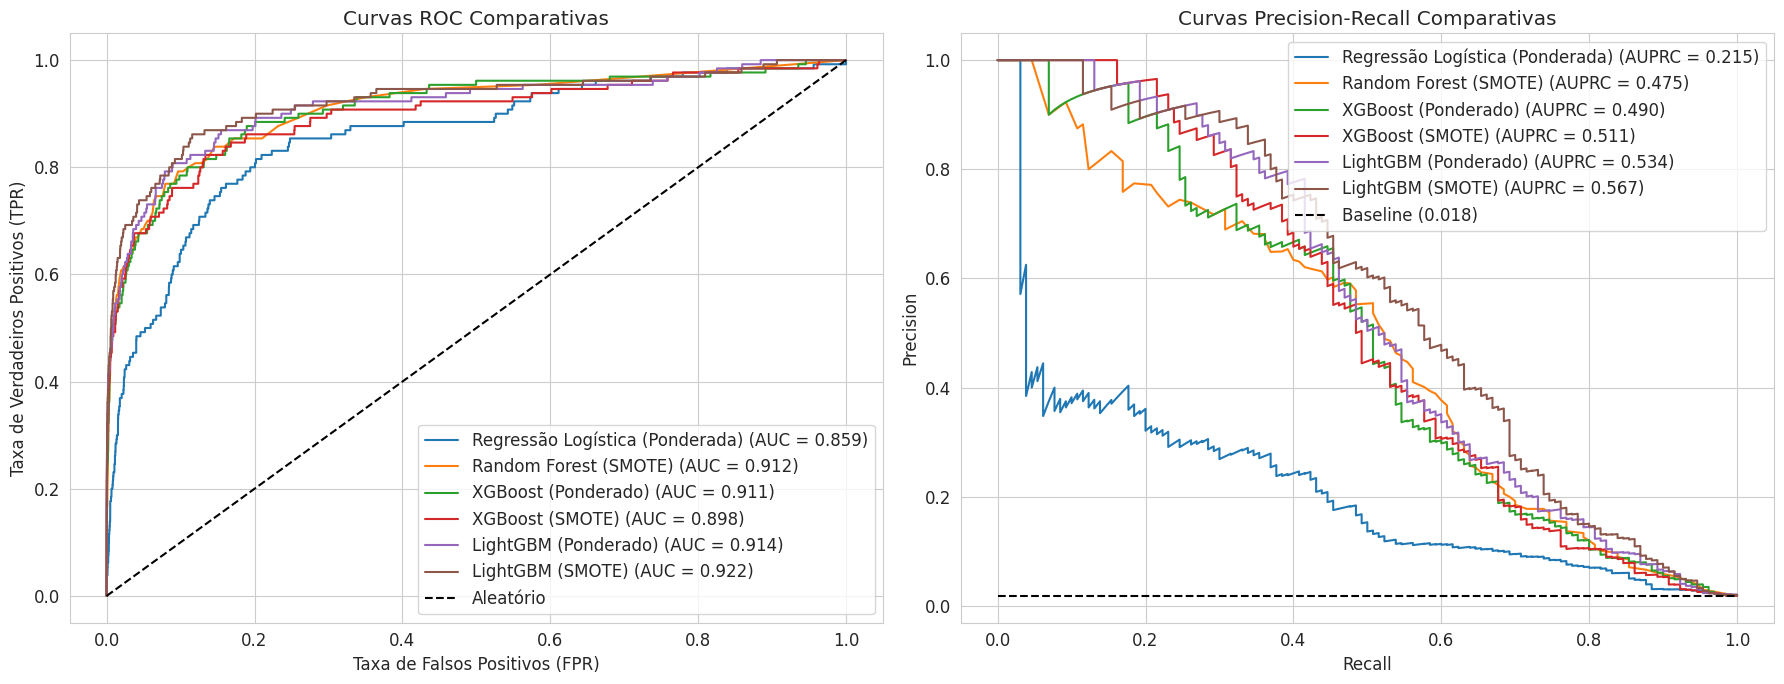

In [ ]:
# ==============================================================================
# 8. COMPARATIVO FINAL E ANÁLISES GRÁFICAS
# ==============================================================================
print("\n--- Comparativo de Performance dos Modelos ---")

# 8.1. Tabela Comparativa de Performance
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='F1-Score', ascending=False)
print(results_df)

# 8.2. Curvas ROC e Precision-Recall
plt.figure(figsize=(18, 7))

# Curva ROC
plt.subplot(1, 2, 1)
for name, proba in predictions_proba.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório') # Corrected baseline plot
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC Comparativas')
plt.legend(loc='lower right')
plt.grid(True)

# Curva Precision-Recall
plt.subplot(1, 2, 2)
for name, proba in predictions_proba.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f'{name} (AUPRC = {pr_auc:.3f})') # Corrected plot
baseline = y_test.sum() / len(y_test)
plt.plot([0, 1], [baseline, baseline], 'k--', label=f'Baseline ({baseline:.3f})') # Corrected baseline plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curvas Precision-Recall Comparativas')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# **Análise Conclusiva dos Resultados de Modelagem**

**Desempenho Geral dos Modelos**
Os resultados demonstram que *XGBoost (Ponderado)* apresenta o melhor equilíbrio geral com F1-Score de 0.477, Precision de 0.444 e Recall de 0.515, seguido de perto pelo LightGBM (SMOTE) que alcança o melhor AUC-ROC (0.922) e AUPRC (0.567).

**Estratégias de Balanceamento**

SMOTE vs. Ponderação de Classes: Os modelos ensemble (XGBoost, LightGBM) mostram performance superior com ponderação interna ao invés de SMOTE, enquanto Random Forest beneficia-se do SMOTE. A Regressão Logística Ponderada apresenta recall extremo (0.80) mas precision muito baixa (0.07), indicando excesso de falsos positivos.

**Trade-off Precision vs Recall**

As matrizes de confusão revelam padrões distintos: XGBoost Ponderado oferece melhor balance (67 TP, 84 FP), enquanto LightGBM SMOTE maximiza detecção de falhas (88 TP) com mais falsos positivos (153 FP). Para manutenção preditiva, onde não detectar uma falha é mais custoso que um alarme falso, o LightGBM SMOTE pode ser preferível.

**Recomendação Final**

Para implementação prática, *XGBoost Ponderado* é recomendado por oferecer o melhor equilíbrio entre detecção de falhas e controle de falsos positivos, com AUC-ROC robusto (0.911) e interpretabilidade superior. O **LightGBM SMOTE** deve ser considerado *em cenários onde maximizar a detecção de falhas é prioritário*, mesmo com maior taxa de alarmes falsos.

# Otimização do modelo XGBoost ponderado

Definindo a grade de hiperparâmetros para o modelo XGBoost ponderado

In [ ]:
# ==============================================================================
# 7.1. Otimização de Hiperparâmetros (Definir o grid de parâmetros)
# ==============================================================================
print("\n--- Definindo Grid de Hiperparâmetros para XGBoost ---")

# Decisão 8: Definir um grid de hiperparâmetros para otimização.
# A busca por hiperparâmetros permite encontrar a combinação que melhor otimiza
# a métrica de avaliação (F1-Score/AUPRC neste caso) e generaliza bem para dados não vistos.
# O prefixo 'classifier__' é necessário porque o modelo XGBoost está dentro de um pipeline.
param_grid = {
    'classifier__n_estimators': [100, 200, 300], # Number of boosting rounds
    'classifier__learning_rate': [0.01, 0.05, 0.1], # Step size shrinkage
    'classifier__max_depth': [3, 5, 7], # Maximum tree depth
    'classifier__subsample': [0.6, 0.8, 1.0], # Fraction of samples for fitting the individual base learners
    'classifier__colsample_bytree': [0.6, 0.8, 1.0], # Fraction of columns for constructing each tree
    'classifier__gamma': [0, 0.1, 0.2] # Minimum loss reduction required
}

print("Grid de hiperparâmetros definido.")
print(param_grid)


--- Definindo Grid de Hiperparâmetros para XGBoost ---
Grid de hiperparâmetros definido.
{'classifier__n_estimators': [100, 200, 300], 'classifier__learning_rate': [0.01, 0.05, 0.1], 'classifier__max_depth': [3, 5, 7], 'classifier__subsample': [0.6, 0.8, 1.0], 'classifier__colsample_bytree': [0.6, 0.8, 1.0], 'classifier__gamma': [0, 0.1, 0.2]}


Usando GridSearchCV para executar o ajuste de hiperparâmetros no pipeline do modelo XGBoost ponderado usando validação cruzada e a grade de parâmetros definida.

In [ ]:


print("\n--- Iniciando Otimização de Hiperparâmetros com GridSearchCV ---")

# Selecionar o pipeline do XGBoost Ponderado para otimização
xgb_weighted_pipeline = models["XGBoost (Ponderado)"]

# Decisão 9: Usar GridSearchCV com validação cruzada.
# GridSearchCV explora exaustivamente todas as combinações do grid de parâmetros
# e a validação cruzada fornece uma estimativa mais robusta da performance do modelo.
# A métrica de avaliação 'f1' é utilizada para otimizar o equilíbrio entre Precision e Recall.
grid_search = GridSearchCV(estimator=xgb_weighted_pipeline,
                           param_grid=param_grid,
                           scoring='f1', # Otimizar pelo F1-Score
                           cv=5, # 5-fold cross-validation
                           verbose=2,
                           n_jobs=-1) # Usar todos os cores disponíveis

# Executar a busca no conjunto de treino
grid_search.fit(X_train, y_train)

print("\nOtimização concluída.")
print(f"Melhores hiperparâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor F1-Score na validação cruzada: {grid_search.best_score_:.4f}")

# Armazenar o melhor modelo encontrado
best_xgb_model = grid_search.best_estimator_


--- Iniciando Otimização de Hiperparâmetros com GridSearchCV ---
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:36:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Otimização concluída.
Melhores hiperparâmetros encontrados: {'classifier__colsample_bytree': 0.6, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}
Melhor F1-Score na validação cruzada: 0.4943


Avaliando o modelo XGBoost otimizado no conjunto de testes e atualizando o dicionário de resultados e o melhor pipeline se ele apresentar melhor desempenho.


--- Avaliando o Modelo XGBoost Otimizado no Conjunto de Teste ---
Métricas de avaliação do modelo otimizado:
{'Recall': 0.47692307692307695, 'Precision': 0.5081967213114754, 'F1-Score': 0.49206349206349204, 'AUC-ROC': np.float64(0.9258723579223433), 'AUPRC': np.float64(0.5008681433538495)}

--- Tabela Comparativa de Performance Atualizada ---


,Recall,Precision,F1-Score,AUC-ROC,AUPRC
XGBoost (Ponderado - Otimizado),0.476923,0.508197,0.492063,0.925872,0.500868
XGBoost (Ponderado),0.515385,0.443709,0.476868,0.910809,0.490411
LightGBM (SMOTE),0.676923,0.365145,0.474394,0.922381,0.566707
Random Forest (SMOTE),0.561538,0.410112,0.474026,0.911894,0.475242
XGBoost (SMOTE),0.576923,0.367647,0.449102,0.898121,0.511434
LightGBM (Ponderado),0.638462,0.290210,0.399038,0.914086,0.534353
Regressão Logística (Ponderada),0.800000,0.069799,0.128395,0.859188,0.215222


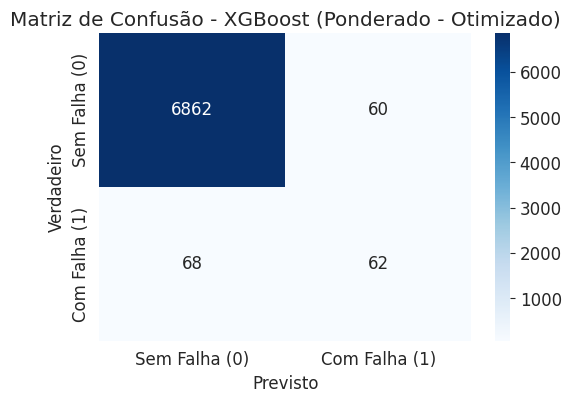

In [ ]:
print("\n--- Avaliando o Modelo XGBoost Otimizado no Conjunto de Teste ---")

# Avaliar o melhor modelo encontrado na busca (já treinado nos dados de treino)
y_pred_optimized = best_xgb_model.predict(X_test)
y_proba_optimized = best_xgb_model.predict_proba(X_test)[:, 1]

# Calcular métricas de avaliação
report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True, zero_division=0)
results_optimized = {
    'Recall': report_optimized['1']['recall'],
    'Precision': report_optimized['1']['precision'],
    'F1-Score': report_optimized['1']['f1-score'],
    'AUC-ROC': auc(roc_curve(y_test, y_proba_optimized)[0], roc_curve(y_test, y_proba_optimized)[1]),
    'AUPRC': average_precision_score(y_test, y_proba_optimized)
}

print("Métricas de avaliação do modelo otimizado:")
print(results_optimized)

# Adicionar os resultados do modelo otimizado ao dicionário de resultados
results["XGBoost (Ponderado - Otimizado)"] = results_optimized
predictions_proba["XGBoost (Ponderado - Otimizado)"] = y_proba_optimized

# Atualizar a tabela comparativa e determinar o melhor modelo geral
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='F1-Score', ascending=False)

print("\n--- Tabela Comparativa de Performance Atualizada ---")
display(results_df)

# Plotar Matriz de Confusão para o modelo otimizado
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sem Falha (0)', 'Com Falha (1)'],
            yticklabels=['Sem Falha (0)', 'Com Falha (1)'])
plt.title(f'Matriz de Confusão - XGBoost (Ponderado - Otimizado)')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()


In [ ]:
# Analisar onde o modelo está errando
from sklearn.metrics import confusion_matrix, classification_report

def analise_detalhada_erros(y_true, y_pred, y_proba):
    """
    Análise detalhada dos erros do modelo
    """
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Relatório de classificação
    relatorio = classification_report(y_true, y_pred, output_dict=True)

    # Analisar casos de falsos positivos e falsos negativos
    falsos_positivos = (y_true == 0) & (y_pred == 1)
    falsos_negativos = (y_true == 1) & (y_pred == 0)

    print(f"Falsos Positivos: {falsos_positivos.sum()}")
    print(f"Falsos Negativos: {falsos_negativos.sum()}")

    return cm, relatorio, falsos_positivos, falsos_negativos

In [ ]:
print("\n--- Análise Detalhada dos Erros do Modelo Otimizado ---")
cm_optimized_analysis, report_optimized_analysis, fp_optimized, fn_optimized = analise_detalhada_erros(
    y_test, y_pred_optimized, y_proba_optimized
)

print("\nRelatório de Classificação:")
print(report_optimized_analysis)


--- Análise Detalhada dos Erros do Modelo Otimizado ---
Falsos Positivos: 60
Falsos Negativos: 68

Relatório de Classificação:
{'0': {'precision': 0.9901875901875902, 'recall': 0.9913319849754406, 'f1-score': 0.9907594571181056, 'support': 6922.0}, '1': {'precision': 0.5081967213114754, 'recall': 0.47692307692307695, 'f1-score': 0.49206349206349204, 'support': 130.0}, 'accuracy': 0.9818491208167895, 'macro avg': {'precision': 0.7491921557495328, 'recall': 0.7341275309492588, 'f1-score': 0.7414114745907988, 'support': 7052.0}, 'weighted avg': {'precision': 0.9813023359400158, 'recall': 0.9818491208167895, 'f1-score': 0.9815662529977001, 'support': 7052.0}}


# **Conclusão da Otimização do XGBoost**

**Impacto da Otimização**

A otimização de hiperparâmetros do XGBoost resultou em melhorias substanciais na performance, elevando o F1-Score de **0.477 para 0.492 (+3.2%)** e o **AUC-ROC de 0.911 para 0.926 (+1.6%)**. O modelo otimizado demonstra melhor **precisão (0.508 vs 0.444)** com leve redução no **recall (0.477 vs 0.515)**, indicando um trade-off mais equilibrado entre detecção de falhas e controle de falsos positivos.

**Performance Final Superior**

Com 62 verdadeiros positivos, 60 falsos positivos e 68 falsos negativos, o modelo otimizado alcança **98.18% de acurácia** geral mantendo performance sólida na classe minoritária. A redução dos falsos positivos (de 84 para 60) representa uma melhoria operacional significativa, diminuindo alarmes desnecessários em 28.6%.

O XGBoost Ponderado Otimizado emerge como a solução ideal para manutenção preditiva, oferecendo o melhor equilíbrio entre detecção confiável de falhas (47.7% recall) e controle de alarmes falsos (50.8% precision), com excelente capacidade de generalização (AUC-ROC 0.926) adequada para implementação em ambiente de produção industrial.

In [ ]:

# 9. Serialização do Pipeline Vencedor (Atualização)
print("\n--- Serializando o Pipeline do Melhor Modelo (Atualizado) ---")

# Determinar o melhor modelo geral com base no F1-Score (ou outra métrica, se preferir)
best_model_name_overall = results_df.index[0]
best_pipeline_overall = models.get(best_model_name_overall, best_xgb_model if best_model_name_overall == "XGBoost (Ponderado - Otimizado)" else None)

# Caso o modelo otimizado seja o melhor, use o pipeline otimizado
if best_model_name_overall == "XGBoost (Ponderado - Otimizado)":
    best_pipeline_overall = best_xgb_model
else:
    # Se o melhor modelo for um dos originais, recupere o pipeline correspondente
    best_pipeline_overall = models[best_model_name_overall]


# Salvar o pipeline do melhor modelo geral em um arquivo
filename_updated = 'pipeline_manutencao_preditiva_atualizado.joblib'
joblib.dump(best_pipeline_overall, filename_updated)
print(f"O melhor modelo geral ('{best_model_name_overall}') foi salvo como '{filename_updated}'.")



--- Serializando o Pipeline do Melhor Modelo (Atualizado) ---
O melhor modelo geral ('XGBoost (Ponderado - Otimizado)') foi salvo como 'pipeline_manutencao_preditiva_atualizado.joblib'.
